Example of explaining regression models with gradient dependent approaches. <br>
https://captum.ai/tutorials/House_Prices_Regression_Interpret


In [ ]:
import numpy as np
from os import path
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

Data loading and pre-processing.

In [2]:
boston = load_boston()

# feature_names -> ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
feature_names = boston.feature_names

X = boston.data
y = boston.target

/home/yangliu/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California 

In [3]:
torch.manual_seed(1234)
np.random.seed(1234)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Data Exploration.

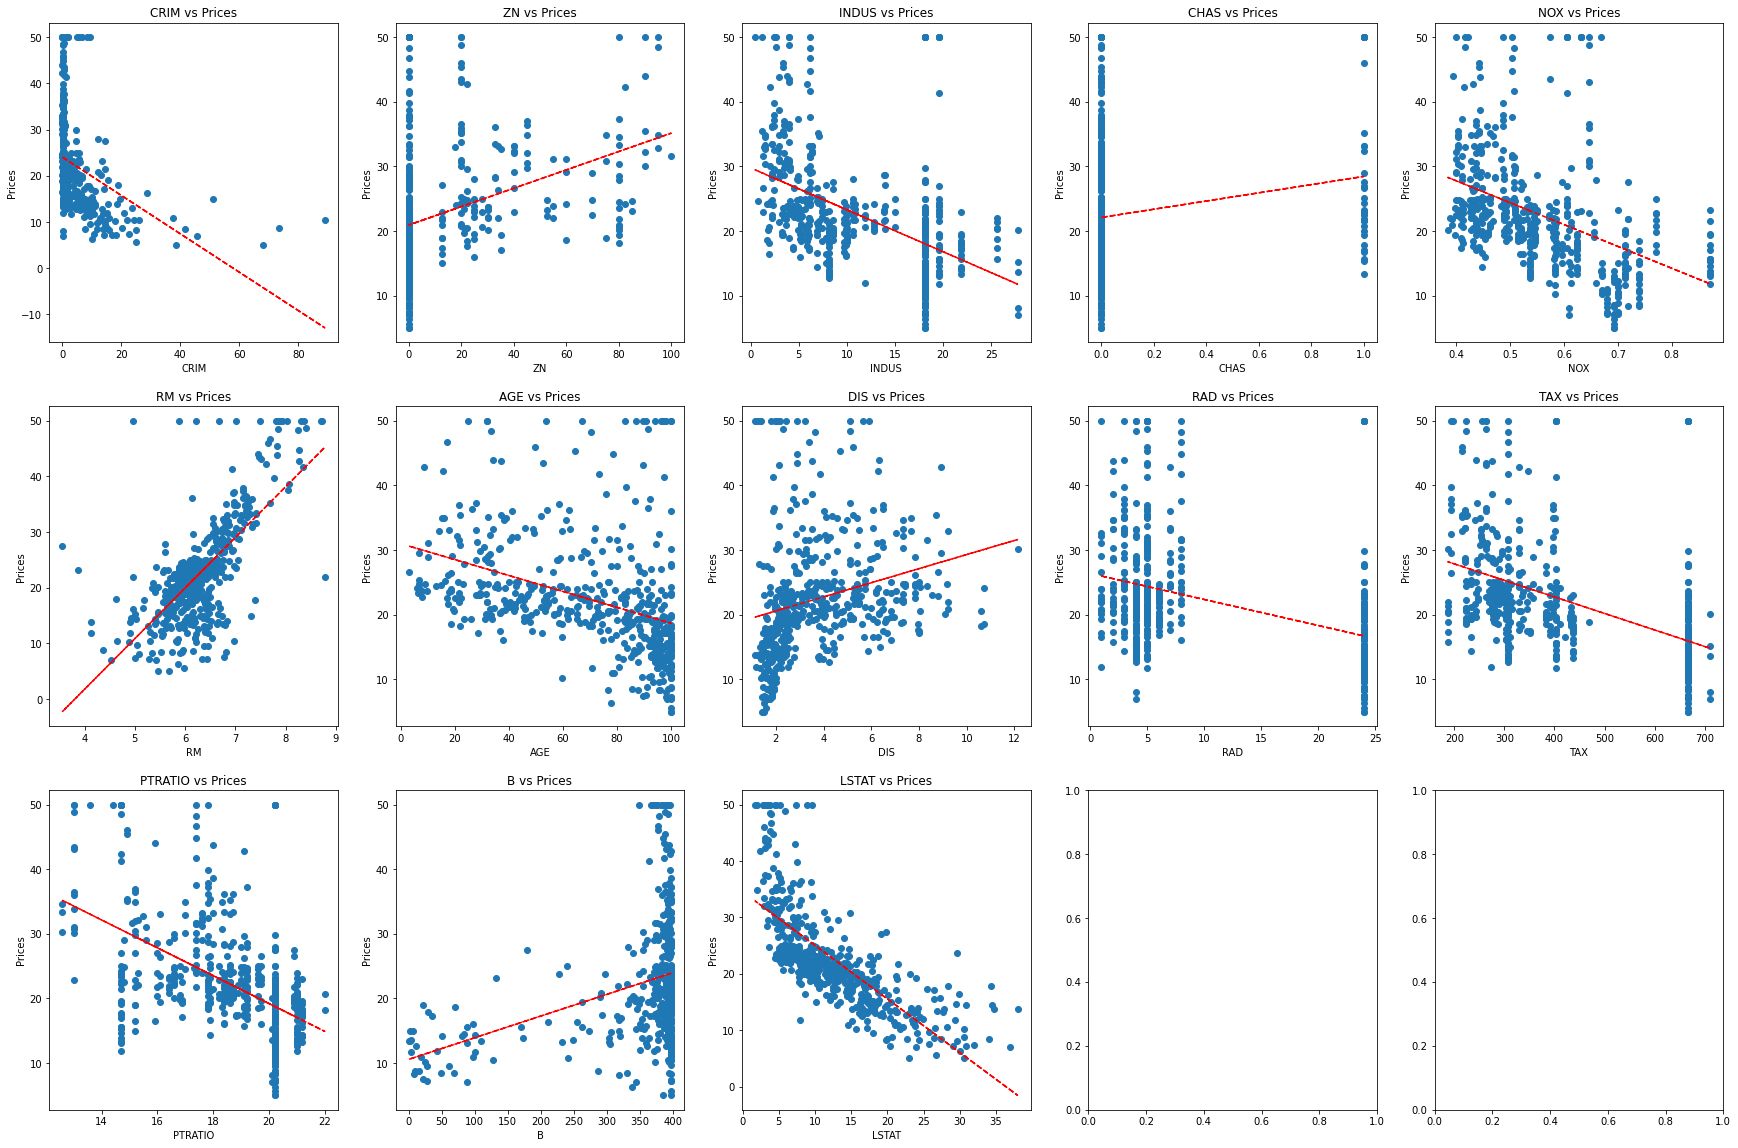

In [5]:
fig, axs = plt.subplots(nrows = 3, ncols=5, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):
    x = X[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs Prices')
    ax.set_xlabel(col)
    ax.set_ylabel('Prices')

From the diagram above we can tell that some of the most influential features that are correlated with the output price are:

- RM, the average numbers of rooms in the houses of the neighborhood. If RM increases the house price increases too.
- LSTAT, the percentage of the house-owners in the neighborhood (lower class). This variable is negatively correlated with the price. The lower the class the less likely is that the person will be able to afford an expensive house.
- PTRATIO, the pupil-teacher ratio by town. If the pupil-teacher ratio increases then the house price decreases, resulting in a negative correlation between ptratio and house price.

Tensorizing inputs and creating batches.

In [6]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [7]:
batch_size = 50
num_epochs = 200
learning_rate = 0.0001
size_hidden1 = 100
size_hidden2 = 50
size_hidden3 = 10
size_hidden4 = 1

In [8]:
class BostonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(13, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

In [9]:
model = BostonModel()
model.train()

BostonModel(
  (lin1): Linear(in_features=13, out_features=100, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=10, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

Train Boston Model.

In [10]:
criterion = nn.MSELoss(reduction='sum')

In [11]:
def train(model_inp, num_epochs = num_epochs):
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

In [12]:
def train_load_save_model(model_obj, model_path):
    if path.isfile(model_path):
        # load model
        print('Loading pre-trained model from: {}'.format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
    else:    
        # train model
        train(model_obj)
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)

In [13]:
SAVED_MODEL_PATH = 'models/boston_model.pt'
train_load_save_model(model, SAVED_MODEL_PATH)

Epoch [1]/[200] running accumulative loss across all batches: 53562.252
Epoch [21]/[200] running accumulative loss across all batches: 19221.868
Epoch [41]/[200] running accumulative loss across all batches: 18055.469
Epoch [61]/[200] running accumulative loss across all batches: 16209.125
Epoch [81]/[200] running accumulative loss across all batches: 14537.516
Epoch [101]/[200] running accumulative loss across all batches: 12581.654
Epoch [121]/[200] running accumulative loss across all batches: 11068.203
Epoch [141]/[200] running accumulative loss across all batches: 10063.119
Epoch [161]/[200] running accumulative loss across all batches: 9383.536
Epoch [181]/[200] running accumulative loss across all batches: 8879.653
Finished training the model. Saving the model to the path: models/boston_model.pt


In [15]:
X_test.shape

torch.Size([152, 13])

In [16]:
X_train.shape

torch.Size([354, 13])

In [14]:
model.eval()
outputs = model(X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

model err:  5.4099193


Comparing different attribution algorithms.

In [17]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

/home/yangliu/miniconda3/envs/ml/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/yangliu/miniconda3/envs/ml/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [18]:
# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

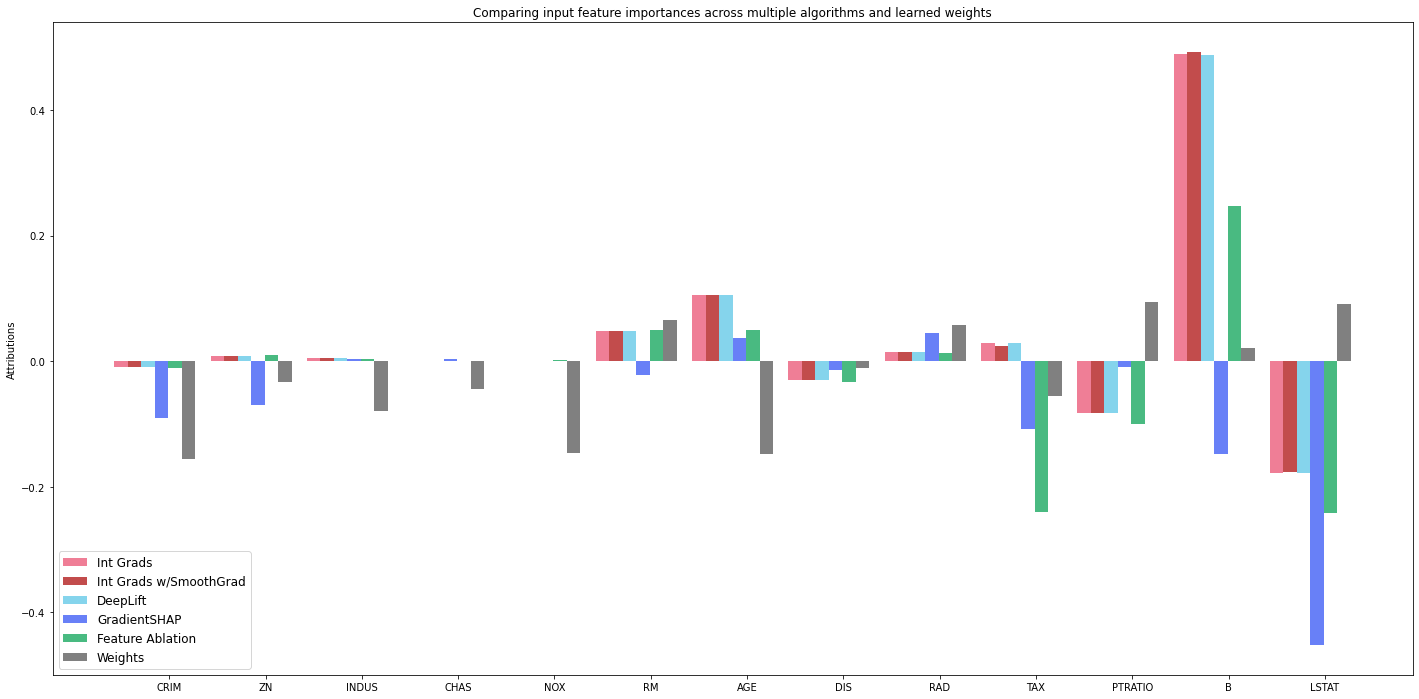

In [19]:
width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()